In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
from scipy.stats import zscore,ttest_ind,norm, hypergeom
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
%matplotlib inline

sns.set(context='talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False,'pdf.fonttype':42,'ps.fonttype':42},palette='colorblind')

# Figure 3 C: Targeted amino acid quantification


## Define the Q-test for identification of outliers in the AA Quantification

In [2]:
q90 = [0.941, 0.765, 0.642, 0.56, 0.507, 0.468, 0.437,
       0.412, 0.392, 0.376, 0.361, 0.349, 0.338, 0.329,
       0.32, 0.313, 0.306, 0.3, 0.295, 0.29, 0.285, 0.281,
       0.277, 0.273, 0.269, 0.266, 0.263, 0.26
      ]

q95 = [0.97, 0.829, 0.71, 0.625, 0.568, 0.526, 0.493, 0.466,
       0.444, 0.426, 0.41, 0.396, 0.384, 0.374, 0.365, 0.356,
       0.349, 0.342, 0.337, 0.331, 0.326, 0.321, 0.317, 0.312,
       0.308, 0.305, 0.301, 0.29
      ]

q99 = [0.994, 0.926, 0.821, 0.74, 0.68, 0.634, 0.598, 0.568,
       0.542, 0.522, 0.503, 0.488, 0.475, 0.463, 0.452, 0.442,
       0.433, 0.425, 0.418, 0.411, 0.404, 0.399, 0.393, 0.388,
       0.384, 0.38, 0.376, 0.372
       ]

Q90 = {n:q for n,q in zip(range(3,len(q90)+1), q90)}
Q95 = {n:q for n,q in zip(range(3,len(q95)+1), q95)}
Q99 = {n:q for n,q in zip(range(3,len(q99)+1), q99)}


def dixon_test(data, left=True, right=True, q_dict=Q95):
    """
    Keyword arguments:
        data = A ordered or unordered list of data points (int or float).
        left = Q-test of minimum value in the ordered list if True.
        right = Q-test of maximum value in the ordered list if True.
        q_dict = A dictionary of Q-values for a given confidence level,
            where the dict. keys are sample sizes N, and the associated values
            are the corresponding critical Q values. E.g.,
            {3: 0.97, 4: 0.829, 5: 0.71, 6: 0.625, ...}

    Returns a list of 2 values for the outliers, or None.
    E.g.,
       for [1,1,1] -> [None, None]
       for [5,1,1] -> [None, 5]
       for [5,1,5] -> [1, None]

    """
    assert(left or right), 'At least one of the variables, `left` or `right`, must be True.'
    assert(len(data) >= 3), 'At least 3 data points are required'
    assert(len(data) <= max(q_dict.keys())), 'Sample size too large'

    sdata = sorted(data)
    Q_mindiff, Q_maxdiff = (0,0), (0,0)

    if left:
        Q_min = (sdata[1] - sdata[0])
        try:
            Q_min /= (sdata[-1] - sdata[0])
        except ZeroDivisionError:
            pass
        Q_mindiff = (Q_min - q_dict[len(data)], sdata[0])

    if right:
        Q_max = abs((sdata[-2] - sdata[-1]))
        try:
            Q_max /= abs((sdata[0] - sdata[-1]))
        except ZeroDivisionError:
            pass
        Q_maxdiff = (Q_max - q_dict[len(data)], sdata[-1])

    if not Q_mindiff[0] > 0 and not Q_maxdiff[0] > 0:
        outliers = [None, None]

    elif Q_mindiff[0] == Q_maxdiff[0]:
        outliers = [Q_mindiff[1], Q_maxdiff[1]]

    elif Q_mindiff[0] > Q_maxdiff[0]:
        outliers = [Q_mindiff[1], None]

    else:
        outliers = [None, Q_maxdiff[1]]

    return outliers

## Read in AA Quant data and metadata

In [3]:
aminos = pd.read_csv(r'data/AA-Results.csv',index_col=[0],header=[0,1])
aminos = aminos.sort_index()

aminos_key = pd.read_csv(r'data/AA-MetaData.csv',index_col=[0],header=[0])

blank=aminos.loc['blank'].melt()
blank.columns=['variable','measure','value']
blank=blank[blank.measure=='Final Conc.']
blank=blank.drop('measure',axis=1)
blank['cond']='blank'
blank

,variable,value,cond
12,Tryptophan (Trp)-pos Results,0.4153,blank
13,Tryptophan (Trp)-pos Results,0.4160,blank
14,Tryptophan (Trp)-pos Results,0.4309,blank
15,Tryptophan (Trp)-pos Results,0.4151,blank
16,Tryptophan (Trp)-pos Results,0.4114,blank
...,...,...,...
1171,Arginine (Arg)-pos Results,0.2365,blank
1172,Arginine (Arg)-pos Results,0.5347,blank
1173,Arginine (Arg)-pos Results,0.2619,blank
1174,Arginine (Arg)-pos Results,0.2252,blank


# Plots results, using Q-test to filter out outliers
* Creates table df_conc, which is used to generate the subsequent figure
* Must run this code for the following segment to work (uses df_conc)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_

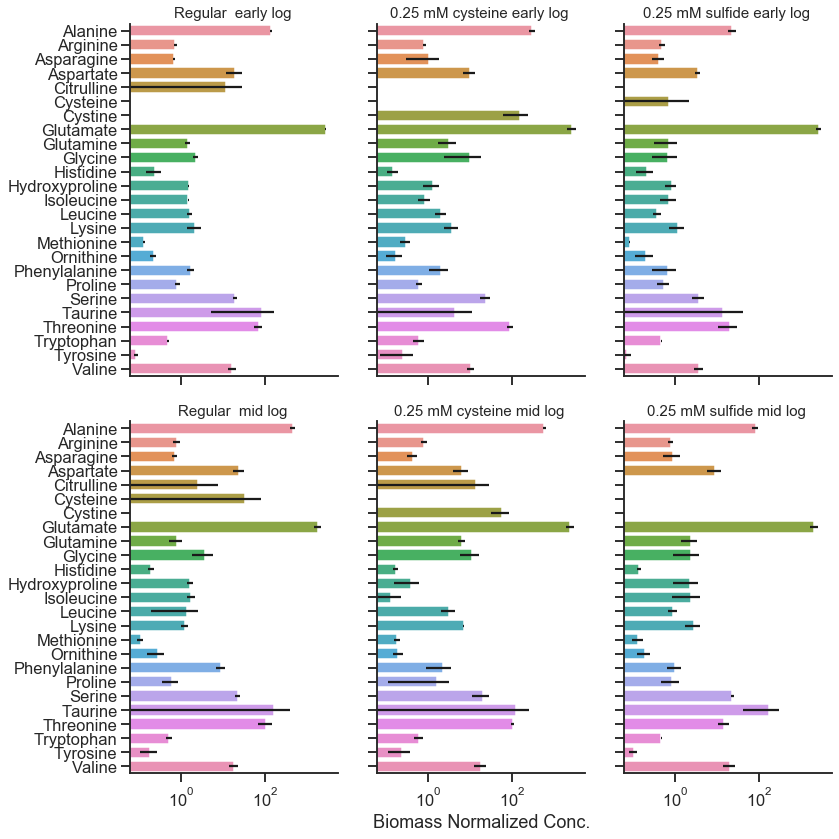

In [4]:
cols = [(x,'Final Conc.') for x in aminos.columns.levels[0].values]
fig,ax = plt.subplots(2,3,figsize=(12,12),sharex=True,sharey=True)
i=0
j=0
df_conc=pd.DataFrame()
for index,df in aminos_key.groupby(by=['Time point','Growth condition']):
    #protein =df['Protein concentration (ug/mL)']
    conc = aminos.loc[df.index.values,cols]
    conc.columns = conc.columns.droplevel(1)
    
    for col in conc.columns:
        x = conc[col]
        if len(x) >= 3:
            res = np.array(dixon_test(x.values))
            res =res[res!=None]
            if len(res)>0:
                x[x==res[0]]=None   
        conc.loc[:,col] = x   
    cond=' '.join([index[1].split('(')[0],index[0]])[:-5]
    if '+' in cond:
        cond=cond.split('+')[1][1:]
    means = conc.mean()
    errors = conc.std()
    temp = conc.melt()
    temp['cond']=cond
    df_conc=pd.concat([df_conc,temp])
    labels = [x.split()[0] for x in conc.columns]
    sns.barplot(y=labels,x=means,xerr=errors,ax=ax[j][i%3])
    ax[j][i%3].set_title(cond,fontsize=15)
    i+=1
    if i%3 == 0 and i>0:
        j=1
    if j == 1 and i%3 == 1:
        ax[j][i%3].set_xlabel('Biomass Normalized Conc.')
#ax[j][i%3].set_xlim(-1,50)
ax[j][i%3].set_xscale('log')
fig.tight_layout()
sns.despine()
df_conc=pd.concat([df_conc,blank])
#plt.savefig('AminoAcid-Quant.png',bbox_inches='tight',dpi=100)

# Figure 3 C
* Be sure you run the code segments above, as this relies on the generation of df_conc
* Plots results with outliers removed on a log scale

Text(0.4, 0, 'Concentration (ug/mL)')

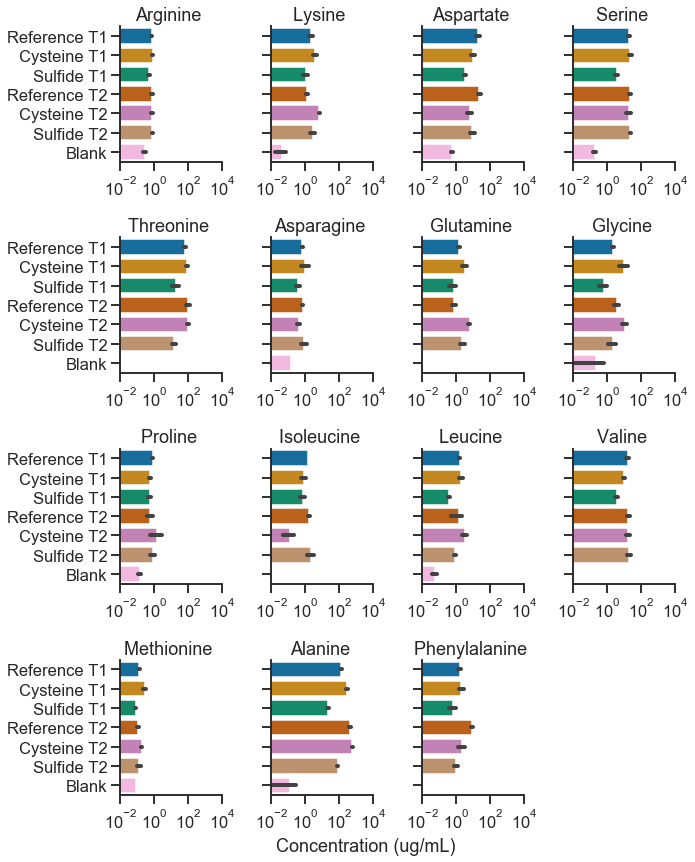

In [5]:
df_conc=df_conc[(df_conc.variable!='Citrulline - pos Results')&(df_conc.variable!='Taurine - pos Results')&(df_conc.variable!='Hydroxyproline (Hyp)-pos Results')]
cond_map={'Regular  early log ':'Reference T1', '0.25 mM cysteine early log ':'Cysteine T1',
       '0.25 mM sulfide early log ': 'Sulfide T1', 'Regular  mid log ':'Reference T2',
       '0.25 mM cysteine mid log ':'Cysteine T2', '0.25 mM sulfide mid log ':'Sulfide T2','blank':'Blank'}
df_conc['labels']=df_conc.cond.map(cond_map)
rows=4
cols=4
fig=plt.figure(figsize=(cols*2.5,rows*3))
ax=plt.subplot(rows,cols,1)
i=1
order=['Arginine (Arg)-pos Results','Lysine (Lys)-pos Results','Aspartate (Asp)-pos Results','Serine (Ser)-pos Results',
       'Threonine (Thr)-pos Results', 'Asparagine (Asn)-pos Results','Glutamine (Gln)-pos Results',
       'Glycine (Gly)-pos Results', 'Proline (Pro)-pos Results',
       'Isoleucine (Ile)-pos Results', 'Leucine (Leu)-pos Results', 'Valine (Val)-pos Results',
        'Methionine (Met)-pos Results',
        'Alanine (Ala)-pos Results',
        'Phenylalanine (Phe)-pos Results']
for measure in order:
    df = df_conc[df_conc.variable==measure]
    g=sns.barplot(y='labels',x='value',data=df,ax=ax)
    #g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_xscale('log')
    g.set_ylabel('')
    g.set_xlabel('')
    g.set_title(measure.split('(')[0])
    if df['value'].max() > 500:
        g.set_xlim(10,10**4)
        #g.set_xticks(range(1,10**4))
    g.set_xlim(.01,10**4)
    g.set_xticks([10**-2,10**0,10**2,10**4])
    if (i-1)%cols != 0:
        g.set_yticklabels('')
    i+=1
    if i <= len(order):
        ax=plt.subplot(rows,cols,i)
    
fig.tight_layout()
fig.text(.4,0,'Concentration (ug/mL)')
#plt.savefig('2020_Targeted_aminos3.pdf',bbox_inches='tight')

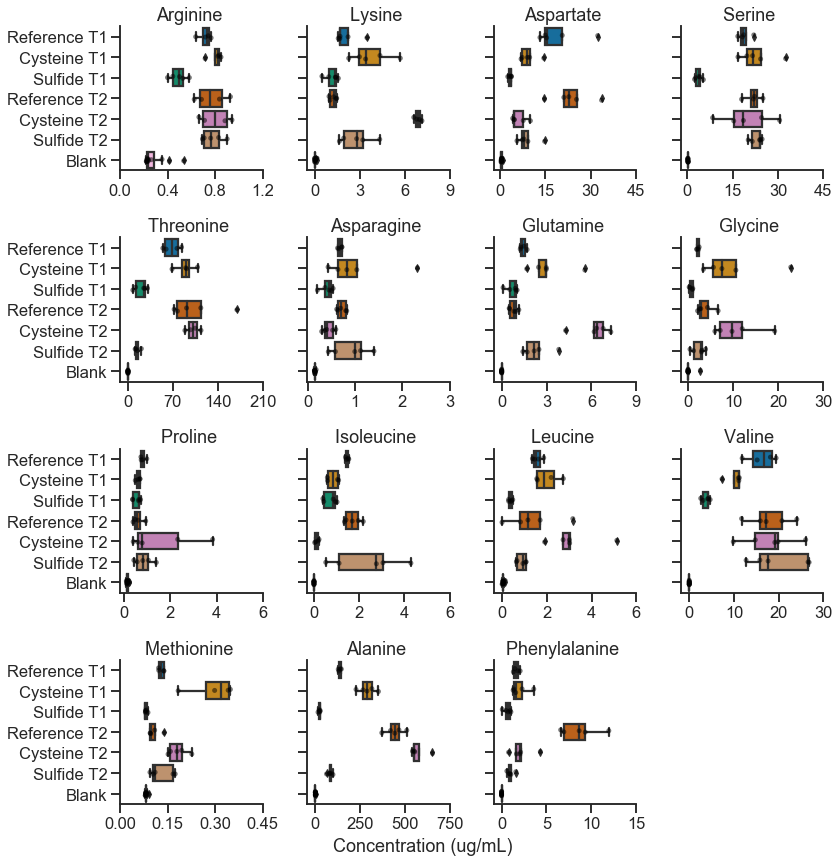

In [105]:
df_conc=df_conc[(df_conc.variable!='Citrulline - pos Results')&(df_conc.variable!='Taurine - pos Results')&(df_conc.variable!='Hydroxyproline (Hyp)-pos Results')]
cond_map={'Regular  early log ':'Reference T1', '0.25 mM cysteine early log ':'Cysteine T1',
       '0.25 mM sulfide early log ': 'Sulfide T1', 'Regular  mid log ':'Reference T2',
       '0.25 mM cysteine mid log ':'Cysteine T2', '0.25 mM sulfide mid log ':'Sulfide T2','blank':'Blank'}
df_conc['labels']=df_conc.cond.map(cond_map)
rows=4
cols=4
fig=plt.figure(figsize=(cols*3,rows*3))
ax=plt.subplot(rows,cols,1)
i=1
order=['Arginine (Arg)-pos Results','Lysine (Lys)-pos Results','Aspartate (Asp)-pos Results','Serine (Ser)-pos Results',
       'Threonine (Thr)-pos Results', 'Asparagine (Asn)-pos Results','Glutamine (Gln)-pos Results',
       'Glycine (Gly)-pos Results', 'Proline (Pro)-pos Results',
       'Isoleucine (Ile)-pos Results', 'Leucine (Leu)-pos Results', 'Valine (Val)-pos Results',
        'Methionine (Met)-pos Results',
        'Alanine (Ala)-pos Results',
        'Phenylalanine (Phe)-pos Results']
for measure in order:
    df = df_conc[df_conc.variable==measure]
    g=sns.boxplot(y='labels',x='value',data=df,ax=ax)
    sns.stripplot(y='labels',x='value',data=df,ax=ax,color='black',alpha=0.5)
    #g.set_xticklabels(g.get_xticklabels(),rotation=90)
    #g.set_xscale('log')
    g.set_ylabel('')
    g.set_xlabel('')
    g.set_title(measure.split('(')[0])
   
    #if df['value'].max() > 500:
        #g.set_xlim(10,10**4)
        #g.set_xticks(range(1,10**4))
    #g.set_xlim(.01,10**2)
    #g.set_xticks([10**-3,10**-2,10**0,10**2])
    if df.value.dropna().max() < 10 and df.value.dropna().max()>1:
        if df.value.dropna().max() < 6:
            if df.value.dropna().max() < 3:
                g.set_xticks([0,1,2,3])
            else:
                g.set_xticks([0,2,4,6])
        else:
            g.set_xticks([0,3,6,9])
    if df.value.dropna().max() > 10 and df.value.dropna().max()<100:
        if df.value.dropna().max() < 30:
            if df.value.dropna().max() < 15:
                g.set_xticks([0,5,10,15])
            else:
                g.set_xticks([0,10,20,30])
        else:
            g.set_xticks([0,15,30,45])
    if df.value.dropna().max() >100:
        if df.value.dropna().max() >500:
            g.set_xticks([0,250,500,750])
        else:
            g.set_xticks([0,70,140,210])
    if df.value.dropna().max() <2:
        if df.value.dropna().max() <.5:
            g.set_xticks([0,.15,.3,.45])
        else:
            g.set_xticks([0,.4,.8,1.2])
    if (i-1)%cols != 0:
        g.set_yticklabels('')
    i+=1
    if i <= len(order):
        ax=plt.subplot(rows,cols,i)
fig.tight_layout()
fig.text(.4,0,'Concentration (ug/mL)')
plt.savefig('2020_Targeted_aminos_boxplot.pdf',bbox_inches='tight')

# Figure 4 C
* Requires above code to be run first (Fig 3 C)

<Figure size 288x288 with 0 Axes>

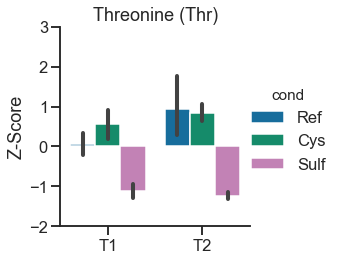

<Figure size 432x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

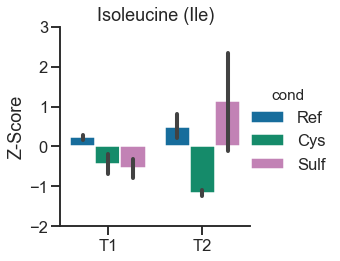

<Figure size 432x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

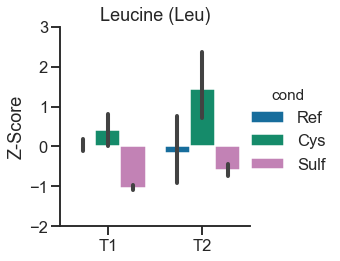

<Figure size 432x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

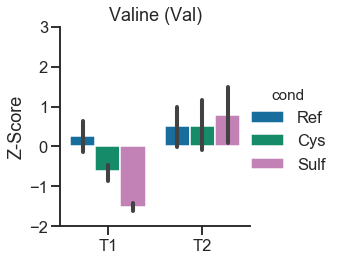

<Figure size 432x288 with 0 Axes>

In [6]:
c=sns.color_palette('colorblind')
c=[c[0],c[2],c[4]]
order=['Threonine (Thr)-pos Results',
       'Isoleucine (Ile)-pos Results', 'Leucine (Leu)-pos Results', 'Valine (Val)-pos Results']
for measure in order:
    df = df_conc[df_conc.variable==measure].dropna()
    df['cond']=df['cond'].map(cond_map)
    df=df[df['cond']!='Blank']
    t=[]
    cond=[]
    for val in df['cond']:
        val=val.split()
        if val[0] !='Sulfide':
            cond.append(val[0][:3])
        else:
            cond.append(val[0][:4])
        t.append(val[1])
    df['cond']=cond
    df['t']=t 

    df['Z-Score']=zscore(df['value'].values)
    plt.figure(figsize=(4,4))
    sns.catplot(x='t',hue='cond',y='Z-Score',data=df,palette=c,kind='bar',height=4)
    #plt.legend(loc=2,bbox_to_anchor=(1,1))
    plt.xlabel('')
    plt.yticks([-2,-1,0,1,2,3])
    plt.title(measure.split('-')[0])
    #plt.savefig(measure.split('-')[0]+'-zscore.pdf',bbox_inches='tight')
    plt.show()
    plt.clf()
    

# Untargeted Metabolomics 
* Results tables used below were generated by XCMS online 

# Figure 4 B
* XCMS online systems biology results 
* Provides pathway dysregulation for multi sample comparison (cys vs reg vs sulf)


In [144]:
sysbio = pd.read_csv(r'data/Untargeted_Met_SysBioRes_All.tsv',sep='\t')
sysbio = sysbio[sysbio['p-values']<=.01]
sysbio['q-values']=multipletests(sysbio['p-values'], method='fdr_bh',alpha=0.01)[:2][1]
sysbio['logp'] = -np.log(sysbio['p-values'])
sysbio = sysbio[sysbio['All metabolites2*']>=4]
sysbio['overlap'] = 100*sysbio['Overlapping putative metabolites1']/sysbio['All metabolites2*']
sysbio = sysbio.sort_values(by=['logp','overlap'],ascending=False)
sysbio

,Pathway,Overlapping genes,Overlapping genes.1,All genes,Overlapping proteins,Overlapping proteins.1,All proteins,Overlapping putative metabolites1,Overlapping putative metabolites1.1,All metabolites2*,p-values,q-values,logp,overlap
0,isoleucine biosynthesis I (from threonine),0,0%,0,0,0%,0,6,54.5%,11,0.00068,0.00660,7.293418,54.545455
2,valine biosynthesis,0,0%,0,0,0%,0,3,60.0%,5,0.00120,0.00660,6.725434,60.000000
3,incomplete reductive TCA cycle,0,0%,0,0,0%,0,4,40.0%,10,0.00120,0.00660,6.725434,40.000000
4,2-oxopentenoate degradation,0,0%,0,0,0%,0,3,42.9%,7,0.00200,0.00792,6.214608,42.857143
5,phosphopantothenate biosynthesis I,0,0%,0,0,0%,0,3,37.5%,8,0.00260,0.00792,5.952244,37.500000
6,respiration (anaerobic),0,0%,0,0,0%,0,4,26.7%,15,0.00300,0.00792,5.809143,26.666667
9,glyoxylate cycle,0,0%,0,0,0%,0,3,30.0%,10,0.00430,0.00792,5.449140,30.000000
10,mixed acid fermentation,0,0%,0,0,0%,0,4,23.5%,17,0.00440,0.00792,5.426151,23.529412
11,catechol degradation to 2-oxopent-4-enoate I,0,0%,0,0,0%,0,2,50.0%,4,0.00540,0.00792,5.221356,50.000000
12,threonine degradation III (to methylglyoxal),0,0%,0,0,0%,0,2,50.0%,4,0.00540,0.00792,5.221356,50.000000


# Names and ordering were further curated using Adobe illustrator 

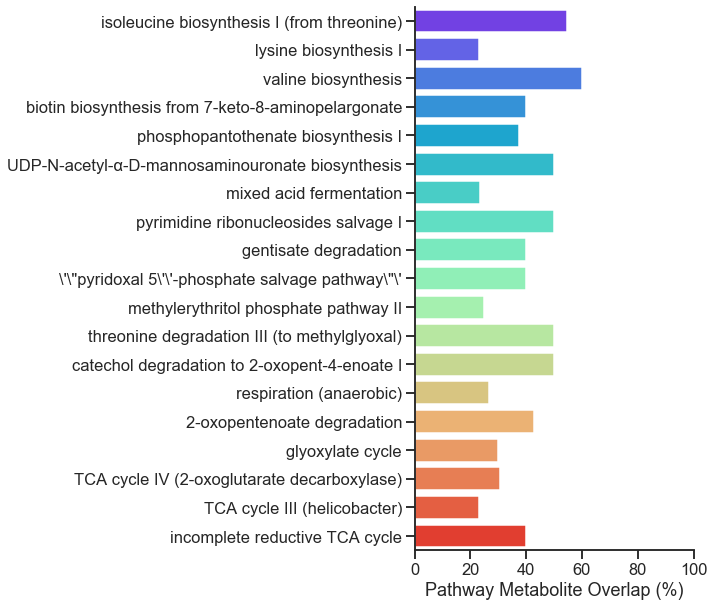

In [147]:
plt.figure(figsize=(5,10))
temp = sysbio[(sysbio['p-values']<=.01)&(sysbio['overlap']>=20)]
sort=[]
for p in temp['Pathway']:
    if 'lysine' in p.lower() or 'valine' in p.lower() or 'isoleucine' in p.lower():
        sort.append('bcaa')
    elif 'biosynthesis' in p.lower():
        sort.append('biosynth')
    elif 'degredation' in p.lower():
        sort.append('deg')
    elif 'glyoxylate' in p.lower() or 'tca' in p.lower():
        sort.append('tca')
    elif 'fermentation' in p.lower():
        sort.append('ferm')
    else:
        sort.append('path')       
temp['sort']=sort
sns.barplot(y='Pathway',x='overlap',data=temp.sort_values(by='sort'),palette='rainbow')
plt.ylabel('')
plt.xlabel('Pathway Metabolite Overlap (%)')

plt.xlim(0,100)
plt.savefig('Metabolite-Pathway-Disregulation.pdf',bbox_inches='tight')


# XCMS Online MultiClass Results (mummichog + feature abundances)

In [149]:
pathway = pd.read_csv(r'data/pathwayanalysis_mummichog_all.csv')
features=pd.read_csv(r'data/XCMS-MultiClass-All.csv',index_col=0)
features

,name,mzmed,mzmin,mzmax,rtmed,rtmin,rtmax,npeaks,Cys_early,Cys_mid,...,Sulf_4,Sulf_5,Sulf_6,Sulf_7,Sulf_8,Sulf_12,Sulf_13,Sulf_14,Sulf_15,Sulf_16
featureidx,,,,,,,,,,,,,,,,,,,,,
1,M911T2_5,911.486746,911.486356,911.489983,2.049583,2.049097,2.059120,3,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
2,M485T23_1,484.638683,484.638013,484.639495,22.604533,22.441633,22.768150,21,4,0,...,2947.131112,5387.786899,10512.508700,9942.933647,11833.788420,37872.27600,41237.29200,33370.244970,44785.12589,57506.10800
3,M514T23_1,514.147566,514.147004,514.148278,22.626633,22.450200,22.784867,23,5,0,...,10228.620210,12739.203810,24752.718460,25444.025700,25487.200520,65906.34182,74647.62785,67433.193000,83768.10200,95294.30221
4,M515T23_1,514.649161,514.648714,514.649834,22.625600,22.450200,22.751433,19,4,0,...,1473.240383,3588.953005,8237.769879,8845.544354,8302.467224,28255.61148,29283.38952,26005.117800,33901.81809,40221.23230
5,M969T23,969.280946,969.279960,969.282163,22.613367,22.441633,22.793250,24,5,0,...,5398.305192,7712.465577,13713.700000,14791.932000,14893.339120,47359.63124,54289.95368,48602.328000,56710.08310,68136.46000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29983,M979T20_4,979.031523,979.026895,979.034959,19.580333,19.436200,19.880550,30,5,5,...,74186.842800,34938.100800,36523.133400,33786.608000,56593.479310,50883.76055,31963.93469,22824.688860,52402.77692,100848.12300
29984,M1061T20_4,1061.034120,1061.030956,1061.038579,19.574900,19.429500,19.682433,29,4,5,...,66480.864000,30224.658160,32453.198770,23956.123900,54586.832500,54786.08250,17157.27391,21367.899470,42938.66087,97891.91788
29985,M567T19_3,566.980125,566.974108,566.980818,19.285067,18.955300,19.505383,35,5,4,...,37974.118000,190839.678200,180341.841400,153501.735500,153928.292800,165492.47160,187036.36970,157449.180500,171034.72650,86020.71200


# Extract feature ID and compound mapping

In [150]:
cmp_dict={}
temp = pathway.loc[:,['overlap_features(id)','overlap_input(featureidx)']].dropna()
for index in temp.index:
    names = temp.loc[index,'overlap_features(id)']
    ids =temp.loc[index,'overlap_input(featureidx)']
    for name, i in zip(names.split(';'),ids.split(';')):
        if ',' in i:
                cmp_dict[name]=[int(x) for x in i.split(',')]
        else:
            cmp_dict[name]=int(i)
cmp_dict

{'CPD-15056': 68,
 '2-ACETO-2-HYDROXY-BUTYRATE': 234,
 'PYRUVATE': [117, 241, 174, 197, 42, 298, 102, 34],
 '1-KETO-2-METHYLVALERATE': [213, 44],
 '2-KETO-3-METHYL-VALERATE': [179, 38],
 'CPD-16013': 68,
 'GLYCEROL-3P': [100, 303],
 'GLYCEROL': 44,
 'CMP': 53,
 '2-KETO-ISOVALERATE': 38,
 '2-ACETO-LACTATE': [161, 184, 234, 158],
 'FUM': 220,
 'SUC': 100,
 'MAL': [220, 241],
 '4-HYDROXY-2-KETOVALERATE': [161, 184, 234, 158],
 'OXOPENTENOATE': [158, 161],
 '2-DEHYDROPANTOATE': 234,
 'L-PANTOATE': [213, 44],
 'GLYOX': 241,
 'CPD-14965': 239,
 'AMINO-OXOBUT': 27,
 'METHYL-GLYOXAL': 184,
 'UMP': 289,
 'UDP-N-ACETYL-D-GLUCOSAMINE': [115, 296],
 'UDP-MANNAC': [115, 296],
 'HYDROXY-METHYL-BUTENYL-DIP': 110,
 'PYRIDOXAL': 239,
 'PYRIDOXINE': 113,
 'DETHIOBIOTIN': 111,
 'S-ADENOSYLMETHIONINE': 242,
 'DELTA1-PIPERIDEINE-2-6-DICARBOXYLATE': [39, 21],
 'AMINO-HYDROXYMETHYL-METHYL-PYR-P': 86,
 'CHORISMATE': 188,
 'ASCORBATE': [34, 117, 197, 298, 42, 174, 102],
 'CPD-329': [34, 117, 197, 298, 42, 174,

In [151]:
rev_cmp_dict ={}
for key in cmp_dict:
    idx = cmp_dict[key]
    if type(idx) != type([]):
        idx = [idx]
    for i in idx:
        if i not in rev_cmp_dict:
            rev_cmp_dict[i]=[key]
        else:
            rev_cmp_dict[i].append(key)
rev_cmp_dict

{68: ['CPD-15056', 'CPD-16013', '2-AMINOACRYLATE'],
 234: ['2-ACETO-2-HYDROXY-BUTYRATE',
  '2-ACETO-LACTATE',
  '4-HYDROXY-2-KETOVALERATE',
  '2-DEHYDROPANTOATE',
  'CPD-13722'],
 117: ['PYRUVATE', 'ASCORBATE', 'CPD-329'],
 241: ['PYRUVATE', 'MAL', 'GLYOX'],
 174: ['PYRUVATE', 'ASCORBATE', 'CPD-329'],
 197: ['PYRUVATE', 'ASCORBATE', 'CPD-329'],
 42: ['PYRUVATE', 'ASCORBATE', 'CPD-329'],
 298: ['PYRUVATE', 'ASCORBATE', 'CPD-329'],
 102: ['PYRUVATE', 'ASCORBATE', 'CPD-329'],
 34: ['PYRUVATE', 'ASCORBATE', 'CPD-329'],
 213: ['1-KETO-2-METHYLVALERATE', 'L-PANTOATE', 'BUTYRIC_ACID'],
 44: ['1-KETO-2-METHYLVALERATE', 'GLYCEROL', 'L-PANTOATE'],
 179: ['2-KETO-3-METHYL-VALERATE', '2K-4CH3-PENTANOATE'],
 38: ['2-KETO-3-METHYL-VALERATE',
  '2-KETO-ISOVALERATE',
  '2-D-THREO-HYDROXY-3-CARBOXY-ISOCAPROATE',
  '2K-4CH3-PENTANOATE',
  '3-CARBOXY-3-HYDROXY-ISOCAPROATE'],
 100: ['GLYCEROL-3P', 'SUC'],
 303: ['GLYCEROL-3P'],
 53: ['CMP'],
 161: ['2-ACETO-LACTATE',
  '4-HYDROXY-2-KETOVALERATE',
  'OXOPE

# Unique feature indexes mapping to a metabolite

In [152]:
idxs = []
for key in cmp_dict:
    if type(cmp_dict[key]) == type(1):
        idxs.append(cmp_dict[key])
    else:
        idxs+=cmp_dict[key]
idxs=pd.unique(idxs)
idxs

array([ 68, 234, 117, 241, 174, 197,  42, 298, 102,  34, 213,  44, 179,
        38, 100, 303,  53, 161, 184, 158, 220, 239,  27, 289, 115, 296,
       110, 113, 111, 242,  39,  21,  86, 188, 262, 247, 171,  49, 153,
        96, 210, 101, 233,  67,  71, 254, 215, 312, 280,  79, 105])

# Feature abundance normalization 
* Convert Area to Log Area
* Convert Log Area to Z-score

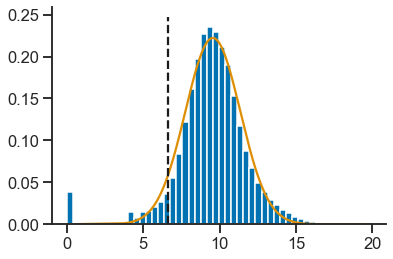

In [153]:
logarea = pd.DataFrame(index=features.index,columns=features.columns[31:],data=features.iloc[:,31:])
logarea=np.log(logarea+1).dropna()

vals = logarea.values.ravel()
hist = plt.hist(vals,bins=50,density=True)
dist = norm(loc=np.median(vals),scale=np.std(vals)/1.25)
plt.plot(sorted(vals),dist.pdf(sorted(vals)))

keep = []
toss = []
cutoff = 0.05
x = dist.ppf(cutoff)
plt.plot((x,x),plt.ylim(),'k--')
for i in logarea.index:
    vals = logarea.loc[i,:].values
    truth = dist.cdf(vals)>cutoff
    if len(truth[truth==True])/len(vals)>.5:
        keep.append(i)
    else:
        toss.append(i)
logarea=logarea.loc[keep,:]

In [154]:
cols = ['Cys_1', 'Cys_1', 'Cys_1', 'Cys_1', 'Cys_1', 'Cys_2', 'Cys_2', 'Cys_2',
       'Cys_2', 'Cys_2', 'Reg_1', 'Reg_1', 'Reg_1', 'Reg_1', 'Reg_1',
       'Reg_2', 'Reg_2', 'Reg_2', 'Reg_2', 'Reg_2', 'Sulf_1', 'Sulf_1',
       'Sulf_1', 'Sulf_1', 'Sulf_1', 'Sulf_2', 'Sulf_2', 'Sulf_2',
       'Sulf_2', 'Sulf_2']
cols = [(x.split('_')[0],x.split('_')[1]) for x in cols]

temp = logarea.copy()
temp.columns = pd.MultiIndex.from_tuples(cols)
avglogarea = temp.groupby(level=[0,1],axis=1).median()
zscores = temp.groupby(level=[0,1],axis=1).median().T.apply(zscore).T
zscores

Cys                 Reg                Sulf          
                   1         2         1         2         1         2
featureidx                                                            
2           0.139815 -2.077243  0.885792  0.776001 -0.209111  0.484747
3          -0.133942 -1.838233  1.128196  0.922728 -0.527024  0.448275
4           0.115952 -2.076387  0.906507  0.780861 -0.184705  0.457773
5           0.026579 -1.984705  1.013676  0.749986 -0.377800  0.572265
6           0.105237 -1.870644  1.060993  0.790479 -0.649394  0.563329
...              ...       ...       ...       ...       ...       ...
29983       1.081408 -0.302608 -0.095585  0.099708 -1.876962  1.094039
29984       1.083481 -0.375817  0.157349  0.148293 -1.942739  0.929433
29985       0.470406  1.072179 -1.822936 -0.776935  0.260781  0.796505
29986       1.151228 -0.782653  0.520241 -0.458928 -1.535637  1.105749
29987       1.381079 -0.660045 -0.857043  0.257514 -1.254223  1.132718

[28508 rows x 6 columns]

# Supplementary Figure 4C: PCA Analysis with all features

Explained Variance... PC1:0.30613375327757675, PC2:0.12063218765258428


Text(0, 0.5, 'PC2 (0.12)')

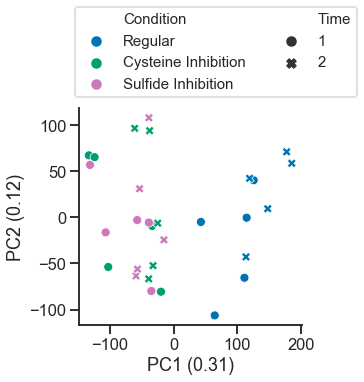

In [16]:
colors=sns.color_palette('colorblind')
cols = ['Cys_1', 'Cys_1', 'Cys_1', 'Cys_1', 'Cys_1', 'Cys_2', 'Cys_2', 'Cys_2',
       'Cys_2', 'Cys_2', 'Reg_1', 'Reg_1', 'Reg_1', 'Reg_1', 'Reg_1',
       'Reg_2', 'Reg_2', 'Reg_2', 'Reg_2', 'Reg_2', 'Sulf_1', 'Sulf_1',
       'Sulf_1', 'Sulf_1', 'Sulf_1', 'Sulf_2', 'Sulf_2', 'Sulf_2',
       'Sulf_2', 'Sulf_2']
cols = [(x.split('_')[0],x.split('_')[1]) for x in cols]
temp = logarea.copy()
temp.columns = pd.MultiIndex.from_tuples(cols)
temp=temp[['Reg','Cys','Sulf']]
logarea2 = temp
pca_data =temp.copy().T
pca_data=pca_data.apply(zscore)
pca = PCA(n_components=2)
color=sns.color_palette('colorblind')
c=[colors[0],colors[2],colors[4]]
pca_coord = pca.fit_transform(pca_data)
pca_coord= pd.DataFrame(pca_coord,index=pca_data.index,columns=['PC1','PC2'])
pca_coord = pca_coord.reset_index()
pca_coord.columns=['Condition','Time','PC1','PC2']
labels = {'Cys':'Cysteine Inhibition','Reg':'Regular','Sulf':'Sulfide Inhibition'}
pca_coord['Condition']=pca_coord['Condition'].map(labels)
print('Explained Variance... PC1:%s, PC2:%s'%tuple(pca.explained_variance_ratio_))
loadings = pd.DataFrame(pca.components_,index=['PC1','PC2'],columns=pca_data.columns)

plt.figure(figsize=(4,4))
sns.scatterplot(x='PC1',y='PC2',hue='Condition',style='Time',data=pca_coord,palette=c)
plt.legend(bbox_to_anchor=(-.05,1.5),ncol=2,loc=2,fontsize=15)
plt.xlabel('PC1 (%s)'%(pca.explained_variance_ratio_[0].round(2)))
plt.ylabel('PC2 (%s)'%(pca.explained_variance_ratio_[1].round(2)))
#plt.savefig('Pred_Metabolites_PCA_All.pdf',bbox_inches='tight')

# Supplementary Figure 4D: PCA Analysis with features mapping to metabolites

Explained Variance... PC1:0.5316343239426855, PC2:0.21420861404263722


Text(0, 0.5, 'PC2 (0.21)')

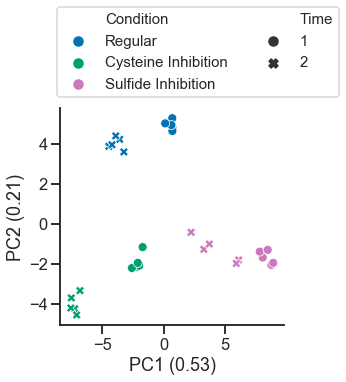

In [76]:
colors=sns.color_palette('colorblind')
cols = ['Cys_1', 'Cys_1', 'Cys_1', 'Cys_1', 'Cys_1', 'Cys_2', 'Cys_2', 'Cys_2',
       'Cys_2', 'Cys_2', 'Reg_1', 'Reg_1', 'Reg_1', 'Reg_1', 'Reg_1',
       'Reg_2', 'Reg_2', 'Reg_2', 'Reg_2', 'Reg_2', 'Sulf_1', 'Sulf_1',
       'Sulf_1', 'Sulf_1', 'Sulf_1', 'Sulf_2', 'Sulf_2', 'Sulf_2',
       'Sulf_2', 'Sulf_2']
cols = [(x.split('_')[0],x.split('_')[1]) for x in cols]
temp = logarea.copy()
temp.columns = pd.MultiIndex.from_tuples(cols)
temp=temp[['Reg','Cys','Sulf']]
logarea2 = temp
pca_data =temp.loc[idxs,:].copy().T
pca_data=pca_data.apply(zscore)
pca = PCA(n_components=2)
color=sns.color_palette('colorblind')
c=[colors[0],colors[2],colors[4]]
pca_coord = pca.fit_transform(pca_data)
pca_coord= pd.DataFrame(pca_coord,index=pca_data.index,columns=['PC1','PC2'])
pca_coord = pca_coord.reset_index()
pca_coord.columns=['Condition','Time','PC1','PC2']
labels = {'Cys':'Cysteine Inhibition','Reg':'Regular','Sulf':'Sulfide Inhibition'}
pca_coord['Condition']=pca_coord['Condition'].map(labels)
print('Explained Variance... PC1:%s, PC2:%s'%tuple(pca.explained_variance_ratio_))
loadings = pd.DataFrame(pca.components_,index=['PC1','PC2'],columns=pca_data.columns)

plt.figure(figsize=(4,4))
sns.scatterplot(x='PC1',y='PC2',hue='Condition',style='Time',data=pca_coord,palette=c)
plt.legend(bbox_to_anchor=(-.05,1.5),ncol=2,loc=2,fontsize=15)
plt.xlabel('PC1 (%s)'%(pca.explained_variance_ratio_[0].round(2)))
plt.ylabel('PC2 (%s)'%(pca.explained_variance_ratio_[1].round(2)))
#plt.savefig('Pred_Metabolites_PCA_All.pdf',bbox_inches='tight')

# Obtain feature pathway mapping

In [155]:
idx=pathway.index[:282]
feature_idx=[]
pathmap={}
for i in idx:
    idx_set=pathway.loc[i,:]['overlap_input(featureidx)']
    if type(idx_set)!=type(''):
        continue
    path =pathway.loc[i,:]['pathway']
    for ID in idx_set.split(';'):
        for j in ID.split(','):
            if int(j) not in feature_idx:
                feature_idx.append(int(j))
            if int(j) not in pathmap:
                pathmap[int(j)]=[path]
            elif path not in pathmap[int(j)]:
                pathmap[int(j)].append(path)
            
pathmap

{68: ['isoleucine biosynthesis I (from threonine)',
  'methionine biosynthesis I',
  'cysteine biosynthesis/homocysteine degradation'],
 234: ['isoleucine biosynthesis I (from threonine)',
  'valine biosynthesis',
  '2-oxopentenoate degradation',
  'phosphopantothenate biosynthesis I',
  'androstenedione degradation'],
 117: ['isoleucine biosynthesis I (from threonine)',
  'valine biosynthesis',
  'incomplete reductive TCA cycle',
  '2-oxopentenoate degradation',
  'respiration (anaerobic)',
  'mixed acid fermentation',
  'methylerythritol phosphate pathway II',
  'gentisate degradation',
  'lysine biosynthesis I',
  'alanine biosynthesis I',
  '4-aminobenzoate biosynthesis',
  'L-ascorbate biosynthesis IV',
  'thiazole biosynthesis I (E. coli)',
  'tryptophan biosynthesis',
  "pyridoxal 5'-phosphate biosynthesis I",
  'gluconeogenesis I',
  'androstenedione degradation',
  'streptomycin biosynthesis',
  'alanine degradation IV',
  'pyruvate fermentation to acetate II',
  'D-fructurona

In [ ]:
def kmeans_cluster(df,k):
    X = df.values
    km = KMeans(n_clusters=k, random_state=0)
    return km.fit_predict(X)

# Figure 3A: Heatmap of feature z-scores for features mapping to metabolites

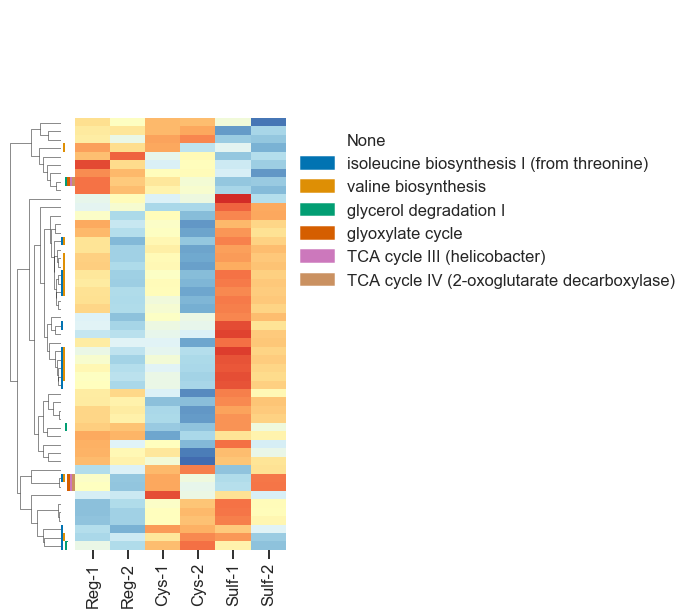

In [18]:
df = pca_data.T.groupby(level=[0,1],axis=1).mean().loc[idxs,:].copy()
df=df[['Reg','Cys','Sulf']]
paths=['isoleucine biosynthesis I (from threonine)','valine biosynthesis','glycerol degradation I','glyoxylate cycle','TCA cycle III (helicobacter)','TCA cycle IV (2-oxoglutarate decarboxylase)']
colors = sns.color_palette('colorblind')
i=0
path_clr = {'None':(1,1,1)}
row_clrs=[]
for p in paths:
    path_clr[p]=colors[i]
    row_clrs.append(pd.Series(index=df.index,data=np.nan))
    for idx in df.index:
        if p in pathmap[idx]:
            row_clrs[i][idx]=p
        else:
            row_clrs[i][idx]='None'
    row_clrs[i]=row_clrs[i].map(path_clr)
      
    i+=1

#If using plt.cm.tab20 then colors[i] must be changed to colors(i)
handles = [mpatches.Patch(color=path_clr[i], label=i) for i in path_clr.keys()]

#Creat heatmap
clust = sns.clustermap(df,cmap='RdYlBu',yticklabels='',figsize=(5,10),col_cluster=False,vmax=-2.5,vmin=2.5,row_colors=row_clrs)
clust.ax_heatmap.set(ylabel='',xlabel='')
clust.cax.set_visible(False)

clust.ax_heatmap.legend(bbox_to_anchor=(1,1),loc=2,handles=handles,frameon=False)
#plt.savefig('Pred-Metabolite-Heatmap.png',bbox_inches='tight',dpi=500)

# Figure 4B: Putative features abundances in BCAA

In [19]:
names=['CPD-15056','1-KETO-2-METHYLVALERATE','2-KETO-3-METHYL-VALERATE','2-ACETO-2-HYDROXY-BUTYRATE','2-KETO-ISOVALERATE','2-ACETO-LACTATE','MAL','GLYCEROL-3P','GLYCEROL']
index=[]
name_dict={}
for name in names:
    if type(cmp_dict[name]) == type([]):
        idx=cmp_dict[name]
    else:
        idx=[cmp_dict[name]]
    
    index+=idx
    for i in idx:
        if i not in name_dict:
            name_dict[i]=name
        else:
            name_dict[i]=name_dict[i] +'/'+name
name_dict

{68: 'CPD-15056',
 213: '1-KETO-2-METHYLVALERATE',
 44: '1-KETO-2-METHYLVALERATE/GLYCEROL',
 179: '2-KETO-3-METHYL-VALERATE',
 38: '2-KETO-3-METHYL-VALERATE/2-KETO-ISOVALERATE',
 234: '2-ACETO-2-HYDROXY-BUTYRATE/2-ACETO-LACTATE',
 161: '2-ACETO-LACTATE',
 184: '2-ACETO-LACTATE',
 158: '2-ACETO-LACTATE',
 220: 'MAL',
 241: 'MAL',
 100: 'GLYCEROL-3P',
 303: 'GLYCEROL-3P'}

In [157]:
multi=[]
for cond in ['cys','reg','sulf']:
    for t in ['T1','T2']:
        for rep in range(1,6):
            multi.append((cond,t,rep))

relabund=(np.exp(logarea)-1).copy()
relabund.columns=pd.MultiIndex.from_tuples(multi)
relabund=relabund/relabund.sum(axis=0)
relabund.sum(axis=0)
relabund

cys                                                  \
                  T1                                                   
                   1             2             3         4         5   
featureidx                                                             
2           0.000003  1.534291e-06  2.482685e-06  0.000003  0.000005   
3           0.000005  3.164120e-06  6.018955e-06  0.000005  0.000010   
4           0.000002  9.313779e-07  1.868791e-06  0.000002  0.000004   
5           0.000002  2.161251e-06  3.400159e-06  0.000004  0.000006   
6           0.000001  7.828048e-07  1.299537e-06  0.000001  0.000002   
...              ...           ...           ...       ...       ...   
29983       0.000009  6.902365e-06  2.084933e-06  0.000004  0.000008   
29984       0.000008  6.814050e-06  1.628057e-06  0.000004  0.000007   
29985       0.000021  5.139379e-07  1.669532e-05  0.000026  0.000028   
29986       0.000014  1.086642e-05  1.330217e-06  0.000003  0.000009   
29987       0.000005  4.113982e-06  9.581834e-07  0.000002  0.000005   

                                                                    \
                      T2                                             
                       1             2             3             4   
featureidx                                                           
2           4.933268e-08  2.033698e-08  2.201864e-08  2.680995e-08   
3           7.142940e-07  7.961235e-07  8.298417e-07  8.040248e-07   
4           2.694299e-08  9.586718e-09  5.254944e-08  3.257441e-08   
5           1.839371e-07  1.307271e-07  1.542928e-07  2.095020e-07   
6           1.333526e-07  1.439539e-07  1.327211e-07  1.715190e-07   
...                  ...           ...           ...           ...   
29983       5.988915e-06  1.520856e-05  2.217725e-06  3.786984e-06   
29984       5.200672e-06  1.541116e-05  1.828297e-06  3.430294e-06   
29985       2.362840e-05  9.235334e-06  1.443436e-05  2.176989e-05   
29986       5.687856e-06  2.549465e-05  1.635998e-06  3.668759e-06   
29987       3.036996e-06  8.714433e-06  8.172636e-07  1.693315e-06   

                          ...          sulf                              \
                          ...            T1                               
                       5  ...             1             2             3   
featureidx                ...                                             
2           7.573280e-08  ...  3.746099e-07  7.089190e-07  1.428266e-06   
3           8.328074e-07  ...  1.300160e-06  1.676210e-06  3.362990e-06   
4           1.207442e-08  ...  1.872636e-07  4.722305e-07  1.119212e-06   
5           2.060366e-07  ...  6.861787e-07  1.014798e-06  1.863191e-06   
6           1.295445e-07  ...  2.969920e-07  3.739778e-07  5.865295e-07   
...                  ...  ...           ...           ...           ...   
29983       1.342991e-05  ...  9.429891e-06  4.597117e-06  4.962160e-06   
29984       1.315275e-05  ...  8.450384e-06  3.976927e-06  4.409204e-06   
29985       3.881321e-05  ...  4.826891e-06  2.511047e-05  2.450187e-05   
29986       2.108254e-05  ...  1.522642e-05  3.808118e-06  5.024457e-06   
29987       7.831434e-06  ...  4.933397e-06  2.087852e-06  2.772300e-06   

                                                                      \
                                              T2                       
                       4             5         1         2         3   
featureidx                                                             
2           1.146211e-06  1.661544e-06  0.000005  0.000005  0.000004   
3           2.933160e-06  3.578576e-06  0.000008  0.000009  0.000009   
4           1.019705e-06  1.165723e-06  0.000004  0.000003  0.000003   
5           1.705198e-06  2.091126e-06  0.000006  0.000006  0.000006   
6           7.060791e-07  8.142010e-07  0.000002  0.000002  0.000002   
...                  ...           ...       ...       ...       ...   
29983       3.894884e-06  7.946109e-06 

1-KETO-2-METHYLVALERATE


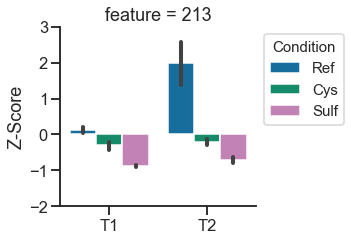

1-KETO-2-METHYLVALERATE/GLYCEROL


<Figure size 432x288 with 0 Axes>

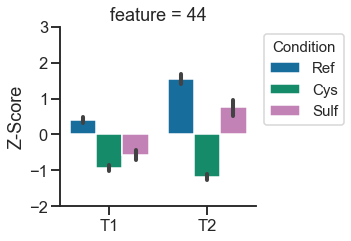

2-ACETO-2-HYDROXY-BUTYRATE/2-ACETO-LACTATE


<Figure size 432x288 with 0 Axes>

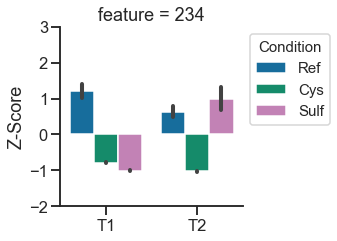

2-ACETO-LACTATE


<Figure size 432x288 with 0 Axes>

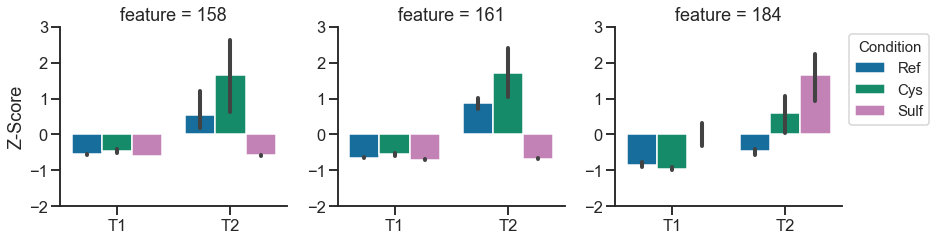

2-KETO-3-METHYL-VALERATE


<Figure size 432x288 with 0 Axes>

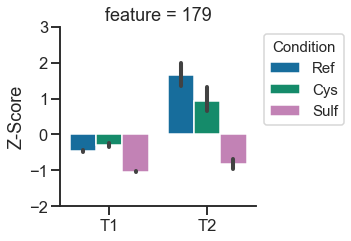

2-KETO-3-METHYL-VALERATE/2-KETO-ISOVALERATE


<Figure size 432x288 with 0 Axes>

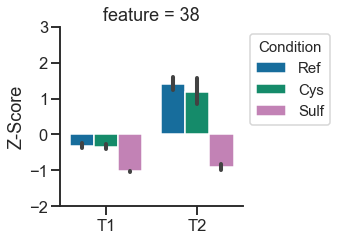

CPD-15056


<Figure size 432x288 with 0 Axes>

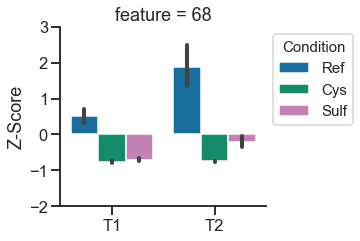

GLYCEROL-3P


<Figure size 432x288 with 0 Axes>

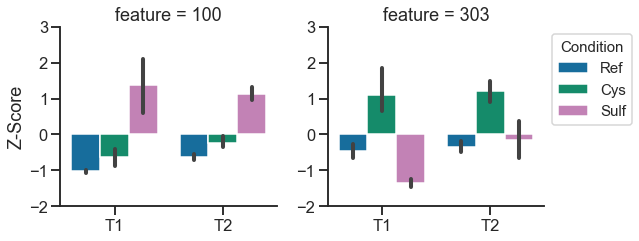

MAL


<Figure size 432x288 with 0 Axes>

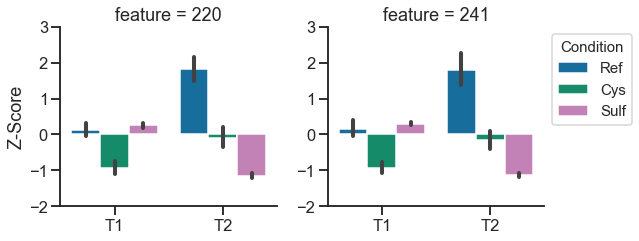

<Figure size 432x288 with 0 Axes>

In [21]:
temp =relabund.T.apply(zscore).T.loc[index,].copy()
df = temp.unstack()
df = df.reset_index()
df['name'] = df['featureidx'].map(name_dict)
df.columns=['cond','t','rep','feature','val','name']
df['cond']=df['cond'].map({'reg':'Ref','cys':'Cys','sulf':'Sulf'})
c = sns.color_palette('colorblind')
c=[c[0],c[2],c[4]]
for name,df2 in df.groupby(by=['name']):
    print(name)
    g = sns.catplot(x="t", y="val",
                hue="cond", col="feature",hue_order=['Ref','Cys','Sulf'],
                data=df2, kind="bar",palette=c,legend=False,sharey=False,height=4)
    g.axes[0][0].set_ylabel('Z-Score')
    for ax in g.axes[0]:
        ax.set_xlabel('')
        ax.set_yticks([-2,-1,0,1,2,3])
    leg=plt.legend(bbox_to_anchor=(1,1),loc=2,title='Condition',fontsize=15)
    leg.get_title().set_fontsize('15')
    #plt.savefig('%s-box.pdf'%('+'.join(name.split('/'))),bbox_inches='tight')
    plt.show()
    plt.clf()

# Supplementary Figure 5: Mycothiol

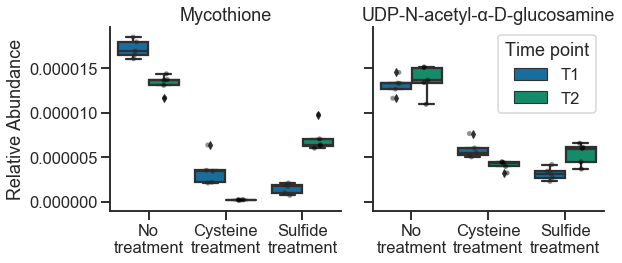

In [166]:
df=pd.DataFrame(relabund.loc[[5,115, 296],:])
df=df.T.reset_index()
df.columns=['cond','time','rep','5','115','296']
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(9,4),sharey=True)
c=sns.color_palette('colorblind')

g=sns.boxplot(x='cond',y='5',hue='time',data=df,palette=[c[0],c[2],c[4]],order=['reg','cys','sulf'],ax=ax1)
sns.stripplot(x='cond',y='5',hue='time',data=df,dodge=True,color='black',alpha=0.5,order=['reg','cys','sulf'],ax=ax1)
g.set_ylabel('Relative Abundance')
g.set_xticklabels(['No\ntreatment','Cysteine\ntreatment','Sulfide\ntreatment'])
g.set_title('Mycothione')
g.set_xlabel('')
g.legend().set_visible(False)
g=sns.boxplot(x='cond',y='296',hue='time',data=df,palette=[c[0],c[2],c[4]],order=['reg','cys','sulf'],ax=ax2)
sns.stripplot(x='cond',y='296',hue='time',data=df,dodge=True,color='black',alpha=0.5,order=['reg','cys','sulf'],ax=ax2)
g.set_ylabel('')
g.set_xlabel('')
handles,labels=g.get_legend_handles_labels()
g.legend(handles[:3],['T1','T2'],bbox_to_anchor=(1,1),title='Time point')
g.set_xticklabels(['No\ntreatment','Cysteine\ntreatment','Sulfide\ntreatment'])
g.set_title('UDP-N-acetyl-α-D-glucosamine')
fig.tight_layout()
plt.savefig('Mycothione-UPD-Relabund.pdf',bbox_inches='tight')

# Supplementary Figure 4 B

68


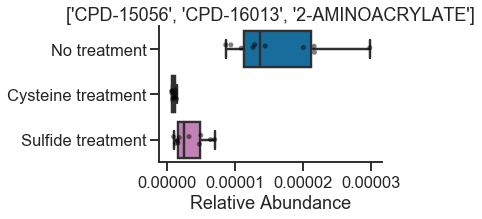

234


<Figure size 432x288 with 0 Axes>

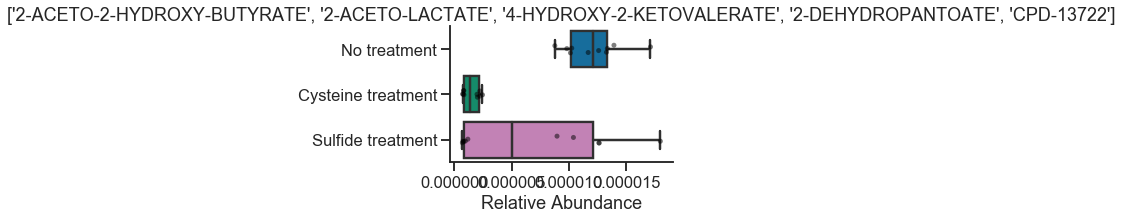

117


<Figure size 432x288 with 0 Axes>

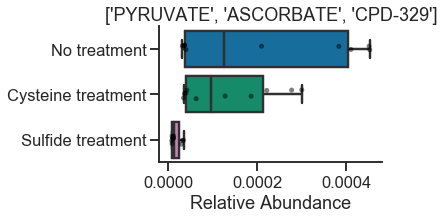

241


<Figure size 432x288 with 0 Axes>

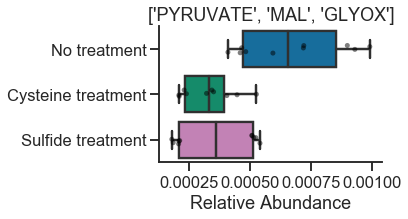

174


<Figure size 432x288 with 0 Axes>

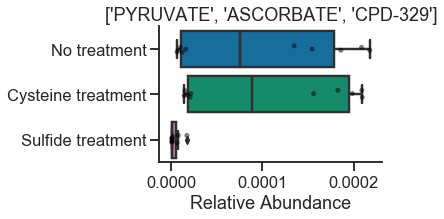

197


<Figure size 432x288 with 0 Axes>

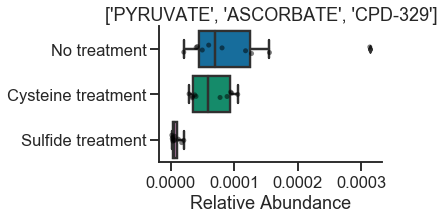

42


<Figure size 432x288 with 0 Axes>

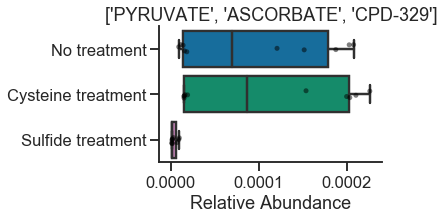

298


<Figure size 432x288 with 0 Axes>

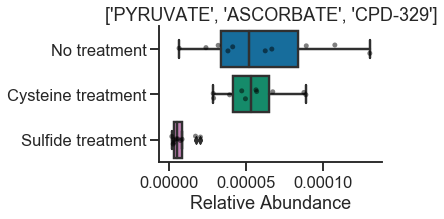

102


<Figure size 432x288 with 0 Axes>

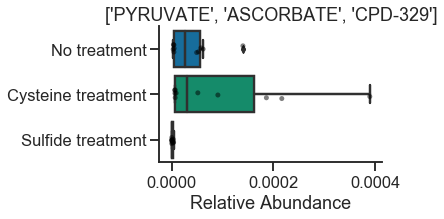

34


<Figure size 432x288 with 0 Axes>

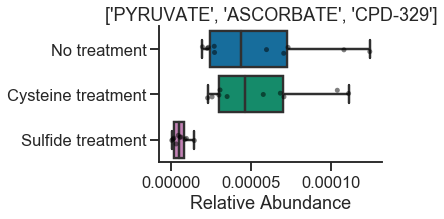

213


<Figure size 432x288 with 0 Axes>

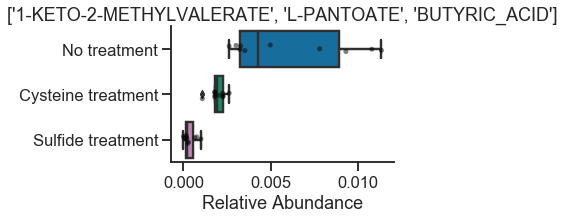

44


<Figure size 432x288 with 0 Axes>

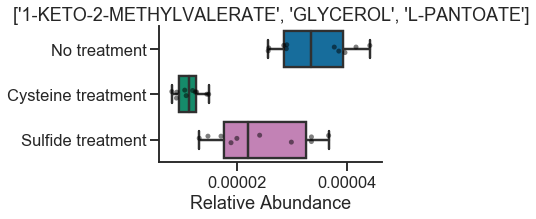

179


<Figure size 432x288 with 0 Axes>

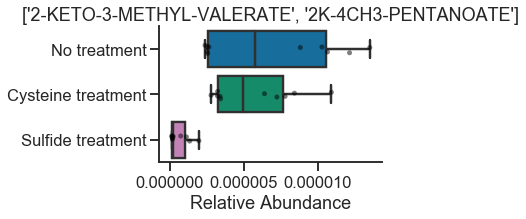

38


<Figure size 432x288 with 0 Axes>

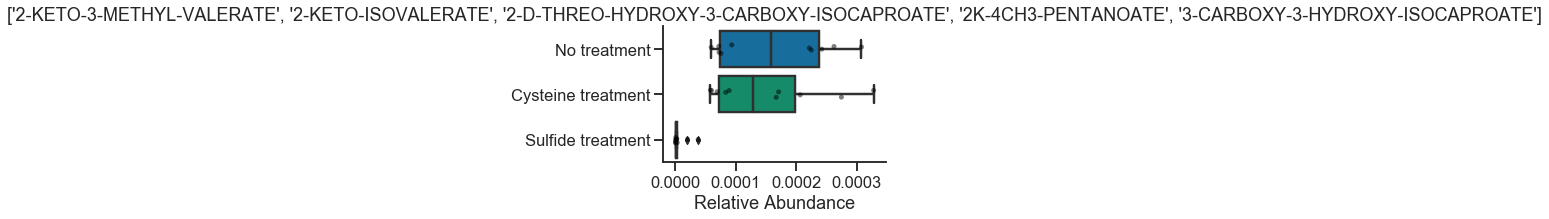

100


<Figure size 432x288 with 0 Axes>

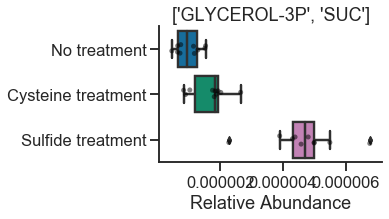

303


<Figure size 432x288 with 0 Axes>

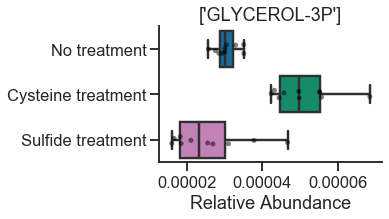

53


<Figure size 432x288 with 0 Axes>

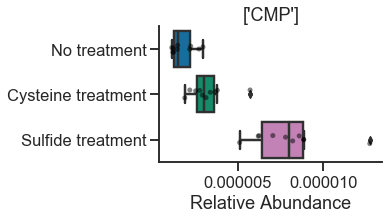

161


<Figure size 432x288 with 0 Axes>

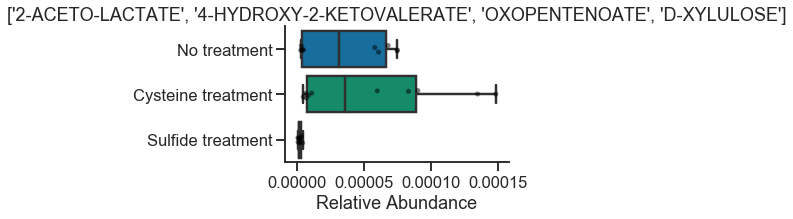

184


<Figure size 432x288 with 0 Axes>

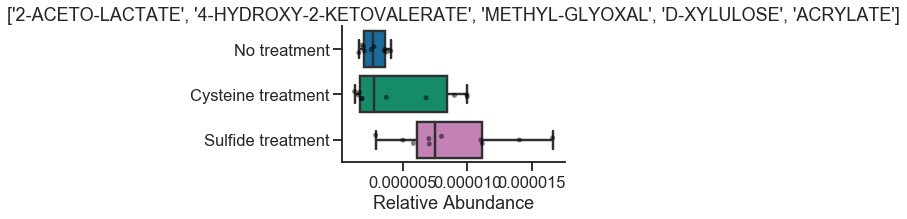

158


<Figure size 432x288 with 0 Axes>

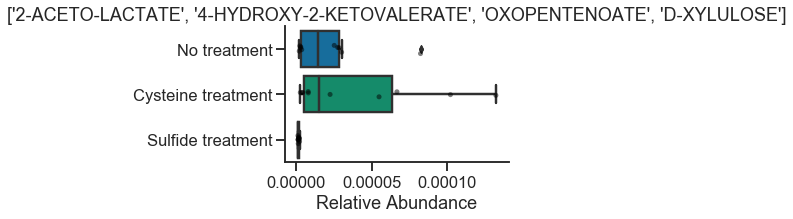

220


<Figure size 432x288 with 0 Axes>

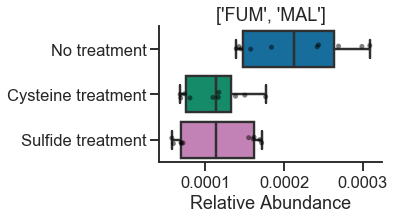

239


<Figure size 432x288 with 0 Axes>

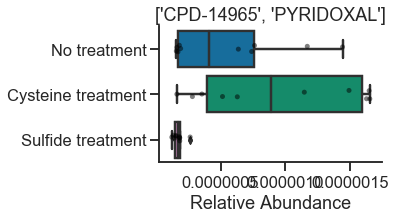

27


<Figure size 432x288 with 0 Axes>

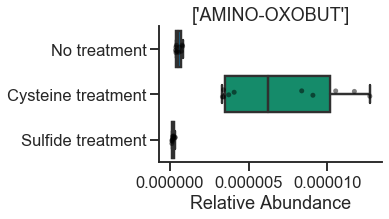

289


<Figure size 432x288 with 0 Axes>

In [ ]:
data=np.exp(logarea2)-1
data=data/data.sum()
cys_pvals=[]
sulf_pvals=[]
cys_sulf_pvals=[]
c=sns.color_palette('colorblind')
for i in idxs:
    df=data.loc[i].reset_index()
    plt.figure(figsize=(4,2.5))
    g=sns.boxplot(y='level_0',x=i,data=df)
    g=sns.boxplot(y='level_0',x=i,data=df,palette=[c[0],c[2],c[4]],order=['Reg','Cys','Sulf'])
    sns.stripplot(y='level_0',x=i,data=df,color='black',alpha=0.5,order=['Reg','Cys','Sulf'])

    g.set_ylabel('')
    g.set_xlabel('Relative Abundance')
    #g.set_xlim(-3.5,3.5)
    g.set_yticklabels(['No treatment','Cysteine treatment', 'Sulfide treatment'])
    reg=df[df['level_0']=='Reg'][i].values
    cys=df[df['level_0']=='Cys'][i].values
    sulf=df[df['level_0']=='Sulf'][i].values
    cys_pval=ttest_ind(reg,cys,equal_var=False).pvalue
    sulf_pval=ttest_ind(reg,sulf,equal_var=False).pvalue
    cys_sulf_pval=ttest_ind(cys,sulf,equal_var=False).pvalue
    cys_pvals.append(cys_pval)
    sulf_pvals.append(sulf_pval)
    cys_sulf_pvals.append(cys_sulf_pval)
    g.set_title(rev_cmp_dict[i])
    print(i)
    #plt.savefig('metabolomics-feat-%s-boxplots.pdf'%(i),bbox_inches='tight')
    plt.show()
    plt.clf()
cys_pvals=multipletests(cys_pvals, method='fdr_bh',alpha=0.01)[:2][1]    
sulf_pvals=multipletests(sulf_pvals, method='fdr_bh',alpha=0.01)[:2][1]   
cys_sulf_pvals=multipletests(cys_sulf_pvals, method='fdr_bh',alpha=0.01)[:2][1]   